In [1]:
import json
import math
import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import OrderedDict

In [2]:
BSM_SIZE = 101347646 # Already counted
N_FEATURES = 22
root_dir = 'VeReMi-Dataset/'
filenames = glob.glob(root_dir + '**/traceJSON*.json', recursive=True)

In [3]:
# # Count the number of BSM messages in the dataset
# \line_num = 0
# for filepath in tqdm(filenames):
#     f = open(filepath)
#     for line in f:
#         if '"type":3' in line:
#             line_num += 1
    
# line_num

In [20]:
attacker_sender_map = {}

datasets = OrderedDict()

for filepath in filenames:
    path_parts = filepath.split('/')
    filename = path_parts[-1]
    dataset_name = path_parts[1]
    _, vehicle, _, attacker = filename.split('-')[:4]
    attacker_type = int(attacker[1:])
    vehicle_id = int(vehicle)
    attacker_sender_map[f'{dataset_name}:{vehicle_id}'] = attacker_type
    datasets[dataset_name] = 1

for i, k in enumerate(datasets.keys()):
    datasets[k] = i

datasets

OrderedDict([('DelayedMessages_0709', 0),
             ('ConstPos_0709', 1),
             ('RandomSpeedOffset_0709', 2),
             ('RandomSpeed_0709', 3),
             ('DoSRandom_1416', 4),
             ('MixAll_0024', 5),
             ('DoS_0709', 6),
             ('ConstSpeedOffset_1416', 7),
             ('ConstSpeedOffset_0709', 8),
             ('ConstPosOffset_1416', 9),
             ('EventualStop_0709', 10),
             ('DataReplay_1416', 11),
             ('DoSRandom_0709', 12),
             ('ConstSpeed_1416', 13),
             ('EventualStop_1416', 14),
             ('DelayedMessages_1416', 15),
             ('GridSybil_1416', 16),
             ('Disruptive_1416', 17),
             ('DoSRandomSybil_1416', 18),
             ('Disruptive_0709', 19),
             ('DoSDisruptiveSybil_1416', 20),
             ('DoSDisruptive_1416', 21),
             ('DoSDisruptiveSybil_0709', 22),
             ('RandomPos_1416', 23),
             ('DataReplaySybil_1416', 24),
           

In [6]:
veremi = np.memmap('veremi.memmap', dtype='float32', mode='w+', shape=(BSM_SIZE, N_FEATURES))
# filenames = filenames[:1000]

veremi_pos = 0
for filepath in (pbar := tqdm(filenames)):
    f = open(filepath)
    path_parts = filepath.split('/')
    filename = path_parts[-1]
    dataset_name = path_parts[1]
    receiver = int(filename.split('-')[1])
    dataset_id = datasets[dataset_name]
    pbar.set_description("Vehicle ID {}".format(receiver))
    gps = None
    for line in f:
        data = json.loads(line)
        if data['type'] == 2:
            gps = data
        elif data['type'] == 3:
            attack_type = attacker_sender_map.get(f'{dataset_name}:{data["sender"]}', None)
            if attack_type is not None:
                out = (
                    dataset_id,
                    data['messageID'],
                    data['rcvTime'],
                    receiver,
                    data['sender'],
                    attack_type,
                    data['pos'][0],
                    data['pos'][1],
                    data['spd'][0],
                    data['spd'][1],
                    data['acl'][0],
                    data['acl'][1],
                    data['hed'][0],
                    data['hed'][1],
                    gps['pos'][0],
                    gps['pos'][1],
                    gps['spd'][0],
                    gps['spd'][1],
                    gps['acl'][0],
                    gps['acl'][1],
                    gps['hed'][0],
                    gps['hed'][1],
                )
                veremi[veremi_pos] = out
                veremi_pos += 1

  0%|          | 0/134082 [00:00<?, ?it/s]

In [3]:
veremi = np.memmap('veremi.memmap', dtype='float32', mode='r', shape=(BSM_SIZE, N_FEATURES))

df = pd.DataFrame(veremi, columns=[
    'dataset_id',
    'message_id',
    'bsm_rcv_time',
    'receiver',
    'sender',
    'attack_type',
    'snd_pos_x',
    'snd_pos_y',
    'snd_spd_x',
    'snd_spd_y',
    'snd_acl_x',
    'snd_acl_y',
    'snd_hed_x',
    'snd_hed_y',
    'rcv_pos_x',
    'rcv_pos_y',
    'rcv_spd_x',
    'rcv_spd_y',
    'rcv_acl_x',
    'rcv_acl_y',
    'rcv_hed_x',
    'rcv_hed_y',
])
df.drop(df[df.attack_type.between(1, 9)].index, inplace=True) # drop faults (1 - 9)
df.sort_values(['dataset_id', 'sender', 'receiver', 'bsm_rcv_time'], inplace=True)
df.reset_index(inplace=True, drop=True)

# Calc delta_time based on the diff between the messages
def calc_delta(x):
    return pd.Series(np.insert(np.diff(x.bsm_rcv_time), 0, 0))

amount_per_iter = 1000000

for i in tqdm(range(math.ceil(len(df) / amount_per_iter))):
    curr_df = df[i * amount_per_iter:(i + 1) * amount_per_iter]
    grouped = curr_df[['dataset_id',
                       'sender',
                       'receiver',
                       'bsm_rcv_time']].groupby(['dataset_id',
                                            'sender',
                                            'receiver'])

    delta_time = grouped.apply(calc_delta)
    df.loc[curr_df.index, 'delta_time'] = delta_time.values

df.to_feather('out_veremi/veremi-full.feather')

In [2]:
df = pd.read_feather('out_veremi/veremi-full.feather')

random_state = 42
grouped = df.groupby(['dataset_id', 'sender', 'receiver', 'attack_type'])
interactions = grouped.size().rename('seq_len').reset_index()

train = interactions.sample(frac=0.8, random_state=random_state)
test = interactions.drop(train.index)

train_full_genuine = train[train.attack_type == 0]

sample_size_5_pctg = round(len(train_full_genuine) / 0.95 - len(train_full_genuine))
train_5_pctg_atk = train[train.attack_type != 0].sample(sample_size_5_pctg, random_state=random_state)
train_95_genuine = pd.concat([train_full_genuine, train_5_pctg_atk]).sample(frac=1, random_state=random_state) # concat and shuffle

sample_size_10_pctg = round(len(train_full_genuine) / 0.9 - len(train_full_genuine))
train_10_pctg_atk = train[train.attack_type != 0].sample(sample_size_10_pctg, random_state=random_state)
train_90_genuine = pd.concat([train_full_genuine, train_10_pctg_atk]).sample(frac=1, random_state=random_state) # concat and shuffle

del train_10_pctg_atk
del train_5_pctg_atk
del interactions
del grouped

print(f'Train: {len(train)}, Train 0%: {len(train_full_genuine)}, Train 5%: {len(train_95_genuine)}, Train 10%: {len(train_90_genuine)}, Test: {len(test)}')

Train: 2845304, Train 0%: 2320616, Train 5%: 2442754, Train 10%: 2578462, Test: 711326


In [3]:
cols = ['dataset_id', 'sender', 'receiver', 'attack_type']

test_df = df.join(test.set_index(cols), how='inner', on=cols)
test_df.reset_index(drop=True).to_feather('out_veremi/test.feather')
del test_df
del test

train_df = df.join(train.set_index(cols), how='inner', on=cols)
train_df.reset_index(drop=True).to_feather('out_veremi/train.feather')
del train_df
del train

train_full_genuine_df = df.join(train_full_genuine.set_index(cols), how='inner', on=cols)
train_full_genuine_df.reset_index(drop=True).to_feather('out_veremi/train_full_genuine.feather')
del train_full_genuine_df
del train_full_genuine

train_95_genuine_df = df.join(train_95_genuine.set_index(cols), how='inner', on=cols)
train_95_genuine_df.reset_index(drop=True).to_feather('out_veremi/train_95_genuine.feather')
del train_95_genuine_df
del train_95_genuine

train_90_genuine_df = df.join(train_90_genuine.set_index(cols), how='inner', on=cols)
train_90_genuine_df.reset_index(drop=True).to_feather('out_veremi/train_90_genuine.feather')
del train_90_genuine_df
del train_90_genuine

In [3]:
V = pd.read_feather('out_veremi/veremi-full.feather')

In [53]:
V[(V.dataset_id == 5) & (V.receiver == 2823) & (V.sender == 2853)]

,dataset_id,message_id,bsm_rcv_time,receiver,sender,attack_type,snd_pos_x,snd_pos_y,snd_spd_x,snd_spd_y,...,snd_hed_y,rcv_pos_x,rcv_pos_y,rcv_spd_x,rcv_spd_y,rcv_acl_x,rcv_acl_y,rcv_hed_x,rcv_hed_y,delta_time
10451776,5.0,3106861.0,19656.548828,2823.0,2853.0,17.0,1117.713745,951.520447,-12.659629,-3.258670,...,-0.113764,1117.713745,951.520447,-12.659629,-3.258670,0.020342,0.005333,-0.993508,-0.113764,0.0
10451777,5.0,3107256.0,19657.548828,2823.0,2853.0,17.0,1105.164307,948.252502,-12.663362,-3.259631,...,-0.113764,1105.164307,948.252502,-12.663362,-3.259631,-0.036132,-0.009205,-0.993508,-0.113764,1.0
10451778,5.0,3107516.0,19658.548828,2823.0,2853.0,17.0,1091.485962,948.015869,-12.729281,-3.276630,...,-0.113758,1091.485962,948.015869,-12.729281,-3.276630,-0.371755,-0.095600,-0.993508,-0.113758,1.0
10451779,5.0,3107766.0,19659.548828,2823.0,2853.0,17.0,1078.807617,944.761597,-12.629001,-3.250817,...,-0.113758,1078.807617,944.761597,-12.629001,-3.250817,0.920817,0.237124,-0.993508,-0.113758,1.0
10451780,5.0,3108011.0,19660.548828,2823.0,2853.0,17.0,1066.107544,941.497681,-12.629025,-3.250532,...,-0.113758,1066.107544,941.497681,-12.629025,-3.250532,0.983901,0.253363,-0.993508,-0.113758,1.0
10451781,5.0,3108291.0,19661.548828,2823.0,2853.0,17.0,1105.164307,948.252502,-12.663362,-3.259631,...,-0.113764,1053.318604,938.228882,-12.729174,-3.270533,-0.996596,-0.255988,-0.993557,-0.113331,1.0
10451782,5.0,3108566.0,19662.548828,2823.0,2853.0,17.0,1040.409790,934.964355,-12.616214,-3.246715,...,-0.109265,1040.409790,934.964355,-12.616214,-3.246715,0.243715,0.062816,-0.994013,-0.109265,1.0
10451783,5.0,3108801.0,19663.548828,2823.0,2853.0,17.0,1027.350220,931.684387,-12.654387,-3.192487,...,-0.088764,1027.350220,931.684387,-12.654387,-3.192487,-0.128804,-0.032405,-0.996053,-0.088764,1.0
10451784,5.0,3109051.0,19664.548828,2823.0,2853.0,17.0,1309.259399,999.452820,-8.156239,-12.851871,...,-0.837399,1014.440186,928.465637,-12.728634,-3.183177,-0.282363,-0.070525,-0.996234,-0.086700,1.0
10451785,5.0,3109381.0,19665.548828,2823.0,2853.0,17.0,1001.723083,924.891907,-12.431164,-4.117805,...,-0.160939,1001.723083,924.891907,-12.431164,-4.117805,-0.241936,-0.080075,-0.986964,-0.160939,1.0


<Axes: xlabel='rcv_pos_x', ylabel='rcv_pos_y'>

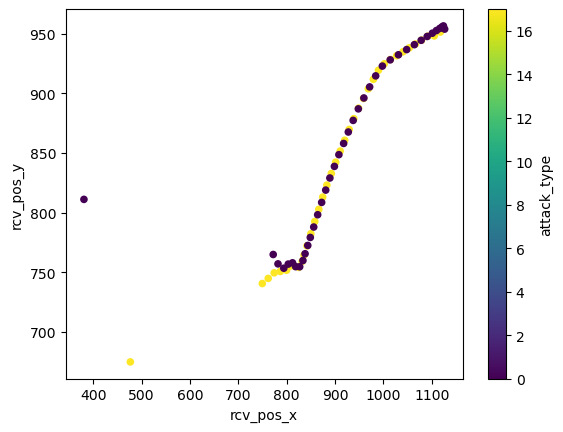